In [1]:
import sys
import os
import pandas as pd
import copy

# Add the parent directory of the 'src' directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("."), "..")))

In [2]:
from transformers import AutoTokenizer
from benchmark_workload_gen import ToolBenchDataLoader, LoadDistribution
from sglang.srt.managers.router.radix_cache import RadixCache

num_workloads = 100
num_requests = 4096
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
dataloader = ToolBenchDataLoader('G1_workload_updated_input_output_lengths_4096_cropped_to_50.json', num_workloads, num_requests, tokenizer, LoadDistribution.EVEN)

In [3]:
workload = dataloader.generate_workload(k=1.1)

4000


In [4]:
import re
def get_tool(workload_item):
    text = workload_item["text"]
    match = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
    if match:
        tool = match.group(1)
        return tool
get_tool(workload[0]), get_tool(workload[1])

('surebets', 'manga_scrapper')

In [96]:
import heapq
import time
from collections import defaultdict
from dataclasses import dataclass
from typing import Tuple

import torch

class TreeNode:
    def __init__(self):
        self.children = defaultdict(TreeNode)
        self.parent = None
        self.value = None
        self.ref_counter = 0
        self.last_access_time = time.time()
        self.gpu_selections = set()

    @property
    def num_tokens(self):
        return len(self.value)
        
    def __lt__(self, other):
        return self.last_access_time < other.last_access_time
    
    def __eq__(self, other):
        if isinstance(other, TreeNode):
            return self.value == other.value
        return False

    def __hash__(self):
        return hash(tuple(self.value))

def match(key, seq):
    i = 0
    for k, w in zip(key, seq):
        if k != w:
            break
        i += 1
    return i


class RadixCache:
    def __init__(self, disable=False):
        self.reset()
        self.disable = disable

    ##### Public API #####

    def reset(self):
        self.root_node = TreeNode()
        self.root_node.value = []
        self.root_node.ref_counter = 1
        self.evictable_size_ = 0

    def match_prefix_get_gpu_selection(self, key):
        if self.disable:
            return [], self.root_node

        value = []
        current_gpu_selection = self.root_node.gpu_selections
        current_gpu_selection = self._match_prefix_helper_gpu_selection(self.root_node, key, value, current_gpu_selection)
        return current_gpu_selection

    def _match_prefix_helper_gpu_selection(self, node, key, value, current_gpu_selection):
        node.last_access_time = time.time()
        child: TreeNode
        for c_key, child in node.children.items():
            prefix_len = match(c_key, key)
            if prefix_len != 0:
                text = tokenizer.decode(child.value)
                if child.gpu_selections:
                    current_gpu_selection = child.gpu_selections
                if "pac" in text:
                    print("pac", child.gpu_selections, current_gpu_selection)
                if prefix_len < len(c_key):
                    assert False
                    new_node = self._split_node(c_key, child, prefix_len, new_nodes_created=new_nodes_created)
                    value.append(new_node.value)
                    # last_node[0] = new_node
                else:
                    value.append(child.value)
                    # last_node[0] = child
                    return self._match_prefix_helper_gpu_selection(child, key[prefix_len:], value, current_gpu_selection)
                break
        return current_gpu_selection

    def match_prefix_return_str(self, key):
        return "".join(self.match_prefix(key)[0])

    def insert(self, key, value=None, node_map=None):
        if node_map is None:
            node_map = {}
        if self.disable:
            return len(key)

        if value is None:
            value = [x for x in key]
        return self._insert_helper(self.root_node, key, value, node_map=node_map)

    def pretty_print(self):
        self._print_helper(self.root_node, 0)
        print(f"#tokens: {self.total_size()}")

    def total_size(self):
        return self._total_size_helper(self.root_node)

    def evict(self, num_tokens, evict_callback):
        if self.disable:
            raise RuntimeError()

        leaves = self._collect_leaves()
        heapq.heapify(leaves)

        num_evicted = 0
        while num_evicted < num_tokens and len(leaves):
            x = heapq.heappop(leaves)

            if x == self.root_node:
                break
            if x.ref_counter > 0:
                continue

            num_evicted += evict_callback(x.value)
            self._delete_leaf(x)

            if len(x.parent.children) == 0:
                heapq.heappush(leaves, x.parent)

    def inc_ref_counter(self, node):
        delta = 0
        while node != self.root_node:
            if node.ref_counter == 0:
                self.evictable_size_ -= len(node.value)
                delta -= len(node.value)
            node.ref_counter += 1
            node = node.parent
        return delta

    def dec_ref_counter(self, node):
        delta = 0
        while node != self.root_node:
            if node.ref_counter == 1:
                self.evictable_size_ += len(node.value)
                delta += len(node.value)
            node.ref_counter -= 1
            node = node.parent
        return delta

    def evictable_size(self):
        return self.evictable_size_

    def _split_node(self, key, child, split_len, node_map):
        # new_node -> child
        is_initial_code_in_node_map = child in node_map
        if is_initial_code_in_node_map:
            lp_node = node_map[child]

        new_node = TreeNode()
        new_node.gpu_selections = copy.deepcopy(child.gpu_selections)
        new_node.children = {
            key[split_len:]: child
        }
        new_node.parent = child.parent
        new_node.ref_counter = child.ref_counter

        new_node.value = child.value[:split_len]
        child.parent = new_node
        child.value = child.value[split_len:]

        new_node.parent.children[key[:split_len]] = new_node
        del new_node.parent.children[key]

        if is_initial_code_in_node_map:
            # NODE Map is updated because splitting the nodes needs to preserve solver state
            node_map[child] = lp_node
            node_map[new_node] = lp_node
            # Potentionally pop the previous entry

        if is_initial_code_in_node_map:
            assert child in node_map
            assert new_node in node_map
        return new_node

    def _insert_helper(self, node, key, value, node_map):
        node.last_access_time = time.time()
        node.ref_counter += 1
        for c_key, child in node.children.items():
            prefix_len = match(c_key, key)

            if prefix_len == len(c_key):
                if prefix_len == len(key):
                    child.ref_counter += 1
                    return prefix_len
                else:
                    key = key[prefix_len:]
                    value = value[prefix_len:]
                    return prefix_len + self._insert_helper(child, key, value, node_map=node_map)

            if prefix_len:
                new_node = self._split_node(c_key, child, prefix_len, node_map)
                return prefix_len + self._insert_helper(
                    new_node, key[prefix_len:], value[prefix_len:], node_map=node_map
                )

        if len(key):
            new_node = TreeNode()
            new_node.gpu_selections = copy.deepcopy(node.gpu_selections)
            new_node.parent = node
            new_node.value = value
            new_node.ref_counter = 1
            node.children[key] = new_node
            self.evictable_size_ += len(value)
        return 0

    def _print_helper(self, node, indent, depth=0):
        if depth == 5:
            return
        for key, child in node.children.items():
            print(" " * indent, len(key), key[:10], f"r={child.ref_counter}")
            self._print_helper(child, indent=indent + 2, depth=depth + 1)
        

    def _delete_leaf(self, node):
        for k, v in node.parent.children.items():
            if v == node:
                break
        del node.parent.children[k]
        self.evictable_size_ -= len(k)

    def _total_size_helper(self, node):
        x = len(node.value)
        for child in node.children.values():
            x += self._total_size_helper(child)
        return x

    def _collect_leaves(self):
        ret_list = []

        def dfs_(cur_node):
            if len(cur_node.children) == 0:
                ret_list.append(cur_node)

            for x in cur_node.children.values():
                dfs_(x)

        dfs_(self.root_node)
        return ret_list


In [97]:
import time
from mip import Model, xsum, BINARY, MINIMIZE, OptimizationStatus, minimize, INTEGER, GUROBI
import random

class LpNode:
    def __init__(self, node_id, num_gpus):
        self.node_id = node_id
        self.variables = [None] * num_gpus  # Will be initialized as binary variables in the model
        self.children_token_cost_at_max_depth = 0 # Issue is that depth_limit will cut off the tokens for children and that will treat it as free
    
class LPTreeTraversal:
    def __init__(self, num_gpus):
        self.num_gpus = num_gpus
        self.node_map = {}  # Maps PrefixTreeNode to LpNode
        self.depth_limit = 5
        self.model = Model(sense=MINIMIZE, solver_name=GUROBI)

    def _traverse_tree(self, current_prefix_node, parent_lp_node=None, depth=0):
        if depth == self.depth_limit:
            assert parent_lp_node is not None
            parent_lp_node.children_token_cost_at_max_depth = self._calculate_children_token_cost(current_prefix_node)
            return
        self.counter += 1
        current_lp_node = LpNode(self.counter, self.num_gpus)
        self.node_map[current_prefix_node] = current_lp_node
        # Initialize binary variables for the LP node
        for gpu in range(self.num_gpus):
            current_lp_node.variables[gpu] = self.model.add_var(f"node_{self.counter}_{gpu}",var_type=BINARY)

        # At least one GPU must be allocated for a prefix
        self.model += xsum(current_lp_node.variables) >= 1

        if parent_lp_node:
            # If the child takes a node, then the parent must also take a node
            for gpu in range(self.num_gpus):
                self.model += current_lp_node.variables[gpu] <= parent_lp_node.variables[gpu]

        for child_prefix_node in current_prefix_node.children.values():
            self._traverse_tree(current_prefix_node=child_prefix_node, parent_lp_node=current_lp_node, depth=depth + 1,)

    def _calculate_children_token_cost(self, node):
        """
        Recursively calculate the total number of tokens for all children of a given node,
        effectively aggregating the tokens for nodes that are beyond the depth limit.
        """
        if node is None:
            return 0
        total_tokens = node.num_tokens
        for child in node.children.values():
            total_tokens += self._calculate_children_token_cost(child)
        return total_tokens

    def add_parent_child_gpu_constraints(self):
        for parent_prefix_node, parent_lp_node in self.node_map.items():
            if not parent_prefix_node.children:  # Skip leaf nodes
                continue
            for gpu_index in range(self.num_gpus):
                children_gpu_selections = []
                for child_prefix_node in parent_prefix_node.children.values():
                    if child_prefix_node in self.node_map:
                        child_lp_node = self.node_map[child_prefix_node]
                        children_gpu_selections.append(child_lp_node.variables[gpu_index])
                if children_gpu_selections:
                    children_selections_total = xsum(children_gpu_selections)
                    self.model += parent_lp_node.variables[gpu_index] <= children_selections_total

    def traverse_and_optimize(self, prefix_tree_root, existing_cost={}):
        start_time = time.time()

        # self.model.reset()  # Re-initialize the model for a new optimization problem
        self.model = Model(sense=MINIMIZE, solver_name=GUROBI)
        self.model.verbose = 0

        self.node_map = {}
        self.counter = 0

        self._traverse_tree(prefix_tree_root)  # Set up variables and base constraints
        self.add_parent_child_gpu_constraints()  # Add parent-child constraints

        # Objective components: Let's assume we're trying to minimize the total cost adjusted for existing costs
        total_cost = []
        per_gpu_cost = [[] for _ in range(self.num_gpus)]
        initial_solution = []
        total_cost_saved = 0
        for prefix_node, lp_node in self.node_map.items():
            node_costs = existing_cost.get(prefix_node, {})
            # children token cost is to account for depth cutoff
            num_tokens_total = prefix_node.num_tokens + lp_node.children_token_cost_at_max_depth
            for gpu_index, var in enumerate(lp_node.variables):
                previous_gpu_selected = existing_cost.get(prefix_node, {}).get(gpu_index, 0) 
                if previous_gpu_selected:
                    initial_solution.append((var, previous_gpu_selected))
                    total_cost_saved += previous_gpu_selected * num_tokens_total

                total_cost.append(var * num_tokens_total - var * previous_gpu_selected * num_tokens_total)
                per_gpu_cost[gpu_index].append(var * num_tokens_total)

        max_per_gpu_cost = self.model.add_var(name='per_gpu_cost_lim', var_type=INTEGER)
        for i in range(self.num_gpus):
            self.model += xsum(per_gpu_cost[i]) <= max_per_gpu_cost
        total_cost_var = self.model.add_var(name='total_cost', var_type=INTEGER)
        self.model += xsum(total_cost) == total_cost_var
    
        self.model.start = initial_solution
        self.model.threads = -1
        self.model.max_mip_gap = 0.01
        setup_time = time.time() - start_time
        start_time = time.time()
        self.model.objective = minimize(total_cost_var + max_per_gpu_cost)
        status = self.model.optimize()

        print(f"exisiting solution", existing_cost, "total_cost_saved", total_cost_saved)
        print(f"max cost per gpu {max_per_gpu_cost.x} {total_cost_var.x}")
        tokens_per_gpu, load_to_gpu = self.calculate_tokens_per_gpu()
        print(f"Tokens per GPU: {tokens_per_gpu} {load_to_gpu}")
        print(f"Objective value: {self.model.objective_value}")

        if status == OptimizationStatus.OPTIMAL:
            print('Optimal solution found.')
        elif status == OptimizationStatus.FEASIBLE:
            print('Feasible solution found, but not necessarily optimal.')
        else:
            print('No feasible solution found.')
        print(f"Solving time: {time.time() - start_time}s Setup Time {setup_time}s")

    def get_exisiting_cost(self):
        existing_cost = {}
        for prefix_node, lp_node in self.node_map.items():
            for gpu_id, var in enumerate(lp_node.variables):
                if prefix_node not in existing_cost:
                    existing_cost[prefix_node] = {}
                if var.x >= 0.99:
                    existing_cost[prefix_node][gpu_id] = 1
                else:
                    existing_cost[prefix_node][gpu_id] = 0
        return existing_cost

    def calculate_tokens_per_gpu(self):
        tokens_per_gpu = {gpu: 0 for gpu in range(self.num_gpus)}  # Reset/initialize
        load_to_gpu = {gpu: 0 for gpu in range(self.num_gpus)}
        for prefix_node, lp_node in self.node_map.items():
            for i, var in enumerate(lp_node.variables):
                if var.x >= 0.99:  # If GPU i is selected by this node, using .x for variable value in MIP
                    tokens_per_gpu[i] += prefix_node.num_tokens  # Accumulate tokens
                    load_to_gpu[i] += prefix_node.ref_counter
        return tokens_per_gpu, load_to_gpu


    def pretty_print(self, prefix_node):
        # This method will call pretty_print_helper and then print additional information
        # Adjustments are mainly in handling variable values using .x in MIP
        self.pretty_print_helper(prefix_node)
        # tokens_per_gpu, load_to_gpu = self.calculate_tokens_per_gpu()
        # print(f"Tokens per GPU: {tokens_per_gpu} {load_to_gpu}")
        # print(f"Objective value: {self.model.objective_value}")

    def pretty_print_helper(self, prefix_node, indent="", depth=0):
        if depth == self.depth_limit:
            return
        lp_node = self.node_map.get(prefix_node)
        if lp_node:
            selected_gpus = [i for i, var in enumerate(lp_node.variables) if var.x >= 0.99]  # Adjust threshold as needed, using .x for variable value
            # if lp_node.node_id == 4 or True:

            def get_tool(workload_item):
                text = tokenizer.decode(workload_item)
                if ":" in text:
                    return text.split(":")[0].strip().replace("\n", " ")
                else:
                    return text[:60].strip().replace("\n", "")
            print(f"{indent}Node {lp_node.node_id} (Tokens: {get_tool(prefix_node.value)}, {len(prefix_node.value)}): GPUs {selected_gpus}")
        else:
            print(f"{indent}Node (Prefix: {len(prefix_node.value)}) has no LP Node mapping")

        for child in prefix_node.children.values():
            self.pretty_print_helper(child, indent + "  ", depth=depth + 1)

    def update_nodes_with_solution(self):
        for prefix_node, lp_node in self.node_map.items():
            prefix_node.gpu_selections = set()
            for gpu_id, var in enumerate(lp_node.variables):
                if var.x >= 0.99:
                    prefix_node.gpu_selections.add(gpu_id)
                    # TODO potentionally set gpu selections for children

class LPScheduler:
    def __init__(self, num_nodes: int, depth_limit=4, update_interval=5):
        self.num_nodes = num_nodes
        self.tree_cache = RadixCache()
        self.shadow_cache = RadixCache()
        self.lp_tree_traversal = LPTreeTraversal(num_nodes)
        self.lp_tree_traversal.depth_limit = depth_limit
        self.metrics_dict = []
        self.counter = 0
        self.update_interval=update_interval
        
    def runtime_selector(self, text: str=None, request_id: str=None, input_ids=None, ):
        # Tokenize the text
        start_time = time.time()

        node_map = self.lp_tree_traversal.node_map
        self.tree_cache.insert(tuple(input_ids), node_map=node_map)
        if self.counter != 0 and self.counter % self.update_interval == 0:
            existing_cost = self.lp_tree_traversal.get_exisiting_cost()
            runtime = self.lp_tree_traversal.traverse_and_optimize(self.tree_cache.root_node, existing_cost=existing_cost)
            self.lp_tree_traversal.update_nodes_with_solution()
        # self.lp_tree_traversal.traverse_and_optimize(self.tree_cache.root_node, existing_cost=self.lp_tree_traversal.get_exisiting_cost())
        # self.shadow_cache = copy.deepcopy(self.tree_cache)

        self.counter += 1
        gpu_selections = self.tree_cache.match_prefix_get_gpu_selection(input_ids)
        if "pac_api" in text:
            self.lp_tree_traversal.pretty_print(self.tree_cache.root_node)
            print(gpu_selections, "GPU SELECTIONS")

        # Randomly select a node from gpu selections
        mode = "not_random"
        if len(gpu_selections) == 0 or len(gpu_selections) == self.num_nodes:
            gpu_selections = set(range(self.num_nodes))
            mode = "random"
        runtime_selected = random.choice(list(gpu_selections))
        # Insert the tokenized text into the radix cache

        self.metrics_dict.append({
            "text": text,
            "rid": request_id,
            "selected_runtime": runtime_selected,
            "overhead": time.time() - start_time,
            "mode": mode
        })
        return runtime_selected

# Example usage (you would need to define the structure of PrefixTreeNode and provide a valid prefix_tree_root):


In [98]:
import random
print(f"Workload length: {len(workload)}")
lp_tree_traversal = LPTreeTraversal(2)
lp_tree_traversal.depth_limit = 4
runtime_selected = []
texts = ["1 sentence. A B C D", "3 sentence. A B C D", "4 sentencee. A B C D", "2 sentence. A B C D", "1 sentence. A B C D example 1", "1 sentence example 2", "2 sentence. A B C D E"]
input_ids = [tokenizer.encode(text) for text in texts]
cache = RadixCache()
for i in range(len(texts)):
    print(f"Request {i}")
    node_map = lp_tree_traversal.node_map
    cache.insert(tuple(input_ids[i]), node_map=node_map)
    existing_cost = lp_tree_traversal.get_exisiting_cost()
    runtime = lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=existing_cost)
    lp_tree_traversal.update_nodes_with_solution()
    lp_tree_traversal.pretty_print(cache.root_node)

# scheduler = LPScheduler(2)
# for i in range(4):
#     print(f"Request {i}")
#     cache.insert(tuple(input_ids[i]))
#     runtime_selected = scheduler.runtime_selector(text=texts[i], request_id=i, input_ids=input_ids[i])
#     print(texts[i],runtime_selected)

Workload length: 4000
Set parameter Username
Request 0
Set parameter Username
exisiting solution {} total_cost_saved 0
max cost per gpu 9.0 9.0
Tokens per GPU: {0: 9, 1: 0} {0: 3, 1: 0}
Objective value: 18.0
Optimal solution found.
Solving time: 0.0005526542663574219s Setup Time 0.007457256317138672s
Node 1 (Tokens: , 0): GPUs [0]
  Node 2 (Tokens: <s> 1 sentence. A B C D, 9): GPUs [0]
Request 1
Set parameter Username
exisiting solution {<__main__.TreeNode object at 0x7f4d71355b20>: {0: 1, 1: 0}, <__main__.TreeNode object at 0x7f4d71507910>: {0: 1, 1: 0}, <__main__.TreeNode object at 0x7f4d84b630a0>: {0: 1, 1: 0}} total_cost_saved 9
max cost per gpu 9.0 9.0
Tokens per GPU: {0: 9, 1: 9} {0: 6, 1: 6}
Objective value: 18.0
Optimal solution found.
Solving time: 0.0017197132110595703s Setup Time 0.004225969314575195s
Node 1 (Tokens: , 0): GPUs [0, 1]
  Node 2 (Tokens: <s>, 2): GPUs [0, 1]
    Node 3 (Tokens: 1 sentence. A B C D, 7): GPUs [0]
    Node 4 (Tokens: 3 sentence. A B C D, 7): GPUs

In [104]:
import random
print(f"Workload length: {len(workload)}")
scheduler = LPScheduler(3, depth_limit=3, update_interval=1)
runtime_selected = []

# input_ids = [tokenizer.encode(text) for text in texts]
# for i in range(len(texts)):
#     runtime = scheduler.runtime_selector(input_ids=input_ids[i], text=texts[i])
#     scheduler.lp_tree_traversal.pretty_print(scheduler.tree_cache.root_node)
#     runtime_selected.append(runtime)
for i in workload:
    runtime = scheduler.runtime_selector(input_ids=i["input_ids"], text=i["text"])
    # scheduler.lp_tree_traversal.pretty_print(scheduler.tree_cache.root_node)
    runtime_selected.append(runtime)

print(pd.DataFrame(scheduler.metrics_dict))
# Write metrics dict to json
import json
with open("metrics_lp_scheduler_2_200.json", "w") as f:
    json.dump(scheduler.metrics_dict, f)


Workload length: 4000
Set parameter Username
Set parameter Username
exisiting solution {} total_cost_saved 0
max cost per gpu 3608.0 4409.0
Tokens per GPU: {0: 0, 1: 3608, 2: 801} {0: 0, 1: 6, 2: 6}
Objective value: 8017.0
Optimal solution found.
Solving time: 0.0077877044677734375s Setup Time 0.005508899688720703s
Set parameter Username
exisiting solution {<__main__.TreeNode object at 0x7f4d717e39a0>: {0: 0, 1: 1, 2: 1}, <__main__.TreeNode object at 0x7f4d71301220>: {0: 0, 1: 1, 2: 1}, <__main__.TreeNode object at 0x7f4d71364be0>: {0: 0, 1: 0, 2: 1}, <__main__.TreeNode object at 0x7f4d713645b0>: {0: 0, 1: 1, 2: 0}} total_cost_saved 4409
max cost per gpu 3608.0 1141.0
Tokens per GPU: {0: 0, 1: 3608, 2: 1942} {0: 0, 1: 8, 2: 9}
Objective value: 4749.0
Optimal solution found.
Solving time: 0.0009906291961669922s Setup Time 0.0068285465240478516s
Set parameter Username
exisiting solution {<__main__.TreeNode object at 0x7f4d717e39a0>: {0: 0, 1: 1, 2: 1}, <__main__.TreeNode object at 0x7f4d

In [ ]:
df = pd.DataFrame(scheduler.metrics_dict)
def get_tool(x):
    text = x
    match = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
    if match:
        tool = match.group(1)
        return tool
    return text
df["text"] = df["text"].map(lambda x: get_tool(x))

df.to_csv("test.csv")

In [ ]:
df

,text,rid,selected_runtime,overhead,mode
0,live_sports_odds,None,0,0.005849,random
1,pinnacle_odds,None,1,0.022328,not_random
2,aspose_ocr_cloud,None,0,0.016718,not_random
3,test_opta,None,2,0.009912,not_random
4,movie_tv_music_search_and_download,None,2,0.015978,not_random
5,world_country,None,0,0.016831,not_random
6,biggest_cities,None,1,0.013942,not_random
7,disney_worlds,None,2,0.014453,not_random
8,pac_api,None,1,0.045309,not_random
9,demo1,None,0,0.013318,not_random


In [ ]:
pivot_table = df.pivot_table(index='text', columns='selected_runtime', aggfunc='size', fill_value=0)

# Rename columns for better clarity
pivot_table.columns = ['selected_runtime_0', 'selected_runtime_1',  'selected_runtime_2']

print(pivot_table)
# pivot table to csv
pivot_table.to_csv("pivot_table.csv")

# Count number of entries that have 0 and non zero
correct = 0
for index, row in pivot_table.iterrows():
    print(f"Index: {index}")
    col_0 = row["selected_runtime_0"]
    col_1 = row["selected_runtime_1"]
    col_2 = row["selected_runtime_2"]
    if (col_0 == 0 and col_1 != 0 and col_2 == 0) or (col_0 != 0 and col_1 == 0 and col_2 == 0) or (col_0 == 0 and col_1 == 0 and col_2 != 0):
        correct += 1

print(f"Correct: {correct} Total: {len(pivot_table)}")
print(f"Accuracy: {correct/len(pivot_table)}")


                                    selected_runtime_0  selected_runtime_1  \
text                                                                         
aspose_cells_cloud                                   1                   0   
aspose_ocr_cloud                                     1                   0   
biggest_cities                                       0                   1   
demo1                                                1                   0   
disney_worlds                                        0                   0   
live_sports_odds                                     1                   0   
movie_tv_music_search_and_download                   0                   0   
pac_api                                              0                   2   
pinnacle_odds                                        0                   1   
test_opta                                            0                   0   
world_country                                        1          

In [103]:
# times = []
# interval = 20
# depth_limit = 4
# lp_tree_traversal = LPTreeTraversal(3)
# lp_tree_traversal.depth_limit = depth_limit
# cache = RadixCache()
# random.shuffle(workload)
# for item in workload:
#     cache.insert(tuple(item["input_ids"]["input_ids"]))

# for i in range(5):
#     start_time = time.time()
#     for item in workload:
#         cache.insert(tuple(item["input_ids"]["input_ids"]))
#     lp_tree_traversal.traverse_and_optimize(cache.root_node, existing_cost=lp_tree_traversal.get_exisiting_cost())
#     lp_tree_traversal.update_nodes_with_solution()
#     lp_tree_traversal.pretty_print(cache.root_node)
#     times.append({"num_nodes": len(lp_tree_traversal.node_map), "time": time.time() - start_time, "total": (i+1)*interval, "depth_limit": depth_limit})

In [199]:
# import pandas as pd
# import matplotlib.pyplot as plt

# time_df = pd.DataFrame(times)

# # Assuming time_df is your DataFrame
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns for subplots

# # Plot on the first subplot
# time_df.plot(ax=axs[0], x="total", y="time", title="Time taken vs Total", marker='o', linestyle='-')
# axs[0].set_xlabel("Total")
# axs[0].set_ylabel("Time (seconds)")

# # Plot on the second subplot
# time_df.plot(ax=axs[1], x="num_nodes", y="time", title="Time taken vs Number of Nodes", marker='o', linestyle='-')
# axs[1].set_xlabel("Number of Nodes")
# axs[1].set_ylabel("Time (seconds)")

# plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area.
# plt.show()


In [65]:
pd.DataFrame(scheduler.metrics_dict )

,text,rid,selected_runtime,overhead,mode
0,"System: You are AutoGPT, you can use many tool...",None,1,0.000102,random
1,"System: You are AutoGPT, you can use many tool...",None,2,0.013655,not_random
2,"System: You are AutoGPT, you can use many tool...",None,2,0.006739,not_random
3,"System: You are AutoGPT, you can use many tool...",None,1,0.009317,not_random
4,"System: You are AutoGPT, you can use many tool...",None,1,0.010489,not_random
5,"System: You are AutoGPT, you can use many tool...",None,0,0.008246,not_random
6,"System: You are AutoGPT, you can use many tool...",None,2,0.008234,not_random
7,"System: You are AutoGPT, you can use many tool...",None,1,0.008854,not_random
8,"System: You are AutoGPT, you can use many tool...",None,2,0.010257,not_random
9,"System: You are AutoGPT, you can use many tool...",None,1,0.012624,not_random


Index with max overhead: 1
Value with max overhead: 0.01365518569946289


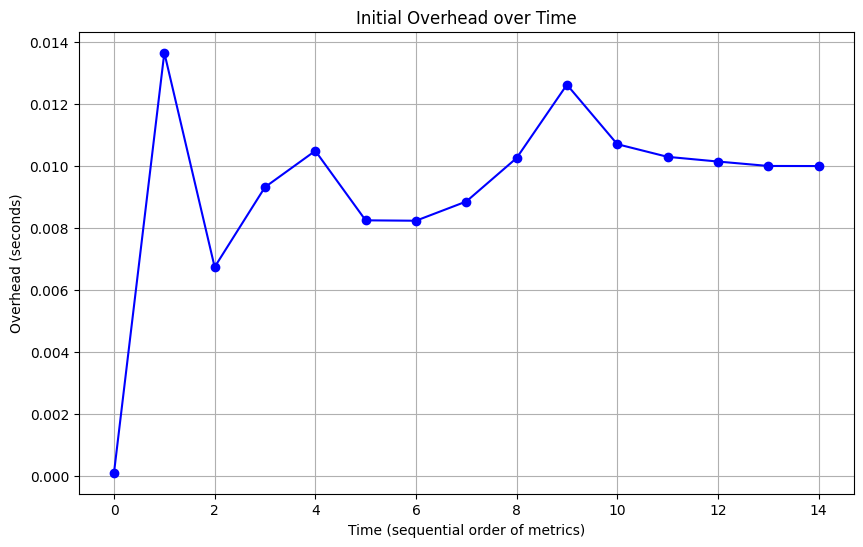

Incorrect prediction for tool: pac_api


93.33333333333333

In [63]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load JSON data
file_name = 'metrics_lp_scheduler_2_200.json'
with open(file_name, 'r') as file:
    data = json.load(file)

# Extract overhead values
overhead_values = [entry['overhead'] for entry in data]
max_index = np.argmax(overhead_values)
max_value = overhead_values[max_index]
print("Index with max overhead:", max_index)
print("Value with max overhead:", max_value)

std_dev = np.std(overhead_values) / 4  # Reduced for visualization purposes
error = [std_dev] * len(overhead_values)
# Initial Plot
plt.figure(figsize=(10, 6))
plt.plot(overhead_values, marker='o', linestyle='-', color='b')
plt.title('Initial Overhead over Time')
plt.xlabel('Time (sequential order of metrics)')
plt.ylabel('Overhead (seconds)')
plt.grid(True)
# plt.savefig('initial_overhead_plot.png')
# plt.close()
plt.show()
# More Smoothed Plot
# more_smoothed_overhead = savgol_filter(overhead_values, 21, 3)
# plt.figure(figsize=(10, 6))
# plt.errorbar(range(len(overhead_values)), more_smoothed_overhead, yerr=error, marker='o', linestyle='-', color='g', ecolor='lightgray', elinewidth=3, capsize=0)
# plt.title('More Smoothed Overhead over Time with Error Bars')
# plt.xlabel('Time (sequential order of metrics)')
# plt.ylabel('Overhead (seconds)')
# plt.grid(True)
# # plt.savefig('more_smoothed_overhead_with_error_bars.png')
# # plt.close()
# plt.show()



# %%
# Initialize a dictionary to map the first 10 characters to the selected runtime
runtime_selection = {}
correct_predictions = 0
ignore_items = 0
import re

for entry in data:
    text = entry['text']
    matched_tool = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
    if matched_tool:
        tool = matched_tool.group(1)
    first_10_chars = tool
    selected_runtime = entry['selected_runtime']
    # If the first 10 characters have been seen before
    if first_10_chars in runtime_selection:
        # Check if the selected runtime matches the previously recorded runtime
        if runtime_selection[first_10_chars] == selected_runtime:
            correct_predictions += 1
        else:
            print(f"Incorrect prediction for tool: {first_10_chars}")
    else:
        # Record the runtime selection for the first 10 characters
        runtime_selection[first_10_chars] = selected_runtime
        # Assuming the first selection is always correct as there's no precedent
        correct_predictions += 1

# Calculate the accuracy
accuracy_percentage = (correct_predictions / (len(data) - ignore_items)) * 100
accuracy_percentage

In [71]:
runtime_selection = {}
first_occurrences = set()  # Keep track of tools that have been seen once
correct_predictions = 0
ignore_items = 0
import re

for entry in data:
    text = entry['text']
    matched_tool = re.search(r"You have access of the following tools:\n1.(.+?): ", text)
    if not matched_tool:
        ignore_items += 1
        continue  # If no tool is matched, skip this entry
    
    tool = matched_tool.group(1)[:10]  # Extract first 10 chars of the tool name
    selected_runtime = entry['selected_runtime']
    
    # Check if it's the first occurrence of the tool
    if tool not in first_occurrences and tool not in runtime_selection:
        first_occurrences.add(tool)  # Mark it as seen for the first time
        ignore_items += 1
        continue  # Move to the next entry without doing anything else
    
    # If it's the second time we see the tool, record its runtime
    if tool in first_occurrences and tool not in runtime_selection:
        runtime_selection[tool] = selected_runtime
        ignore_items += 1
        continue  # Move to the next entry after recording the second runtime
    
    # From the third occurrence onwards, we check predictions
    if tool in runtime_selection:
        if runtime_selection[tool] == selected_runtime:
            correct_predictions += 1
        else:
            print(f"Incorrect prediction for tool: {tool}")

print(f"Correct predictions (excluding first occurrences): {correct_predictions}")
accuracy_percentage = (correct_predictions / (len(data) - ignore_items)) * 100
accuracy_percentage

Incorrect prediction for tool: ipl_api
Incorrect prediction for tool: nba_statis
Incorrect prediction for tool: seo_checke
Incorrect prediction for tool: dota2_hero
Incorrect prediction for tool: fear_and_g
Incorrect prediction for tool: calltracki
Incorrect prediction for tool: get_10000_
Incorrect prediction for tool: manga_scra
Incorrect prediction for tool: dota_2_ste
Incorrect prediction for tool: store_apps
Incorrect prediction for tool: cigars
Incorrect prediction for tool: seeking_al
Incorrect prediction for tool: seo_checke
Incorrect prediction for tool: musiclinks
Incorrect prediction for tool: dota_2_ste
Incorrect prediction for tool: instagram_
Incorrect prediction for tool: manga_scra
Incorrect prediction for tool: hryvna_tod
Incorrect prediction for tool: seo_checke
Incorrect prediction for tool: cigars
Incorrect prediction for tool: proxypage
Incorrect prediction for tool: cigars
Incorrect prediction for tool: world_coun
Incorrect prediction for tool: famous_quo
Incorrec

49.01315789473684